# Supplemental Information:

> **"Clonal heterogeneity influences the fate of new adaptive mutations"**

> Ignacio Vázquez-García, Francisco Salinas, Jing Li, Andrej Fischer, Benjamin Barré, Johan Hallin, Anders Bergström, Elisa Alonso-Pérez, Jonas Warringer, Ville Mustonen, Gianni Liti

## Figure 4 (+ Supp. Figs.)

This IPython notebook is provided for reproduction of Figures 4 and S5 of the paper. It can be viewed by copying its URL to nbviewer and it can be run by opening it in binder.

In [1]:
# load external dependencies
import numpy as np
from scipy import stats
import pandas as pd # (*) Pandas for data manipulation

import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
import matplotlib.lines as lines
import matplotlib.patches as patches
import matplotlib.patheffects as PathEffects
%matplotlib inline

import json,matplotlib
s = json.load( open("matplotlibrc.json") )
matplotlib.rcParams.update(s)

# load internal dependencies
import colors,plot,utils,config

# absolute file path for root directory of git repo
dir_repo = utils.get_git_path()
dir_data = dir_repo+"/data/"
dir_paper = dir_repo+"/manuscript/main/"
dir_supp = dir_repo+"/manuscript/supp/"

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
# %run load_datasets.py --redo

## Data import

### Chromosome length

In [3]:
chr_coords = utils.chr_coords()

chr_coords.head()

,chr_arabic,chr_length,chr_roman,chr_start,chr_end
0,1,230218,I,0,230218
1,2,813184,II,230218,1043402
2,3,316620,III,1043402,1360022
3,4,1531933,IV,1360022,2891955
4,5,576874,V,2891955,3468829


### Ancestral and evolved isolate genomes

* *De novo* SNVs and indels in ancestral and evolved isolate genomes

In [4]:
# load data
seq_mut_df = utils.load_data(dir_data+'seq/de-novo/seq_de_novo_snps_indels.pickle')

seq_mut_df = seq_mut_df.rename(columns={'chrom':'chr_arabic', 'pos':'site'})
seq_mut_df['chr_roman'] = seq_mut_df['chr_arabic'].apply(utils.int_to_roman)
seq_mut_df = utils.chr_to_gw(seq_mut_df, chr_coords)

seq_mut_df = seq_mut_df[(seq_mut_df.clone!='')].reset_index(drop=True)

# remap genotype values
seq_mut_df['genotype'] = seq_mut_df['genotype'].map({'0': 0, '1': 2,'0/0': 0, '0/1': 1, '1/0': 1, '1/1': 2})

seq_mut_df['type'] = 'snp_indel'

seq_mut_df.head()

,ac,af,alt,an,allele,amino_acids,biotype,baseqranksum,cds_position,chr_arabic,...,substitution,assignment,mutation_type,consequence_short,chr_roman_x,chr_length,chr_roman_y,pos,chr_roman,type
0,1,0.5,[A],2.0,A,R/I,protein_coding,1.723,101,7,...,C>A,bulk,driver,non-synonymous,VII,1090940,VII,4595191.0,VII,snp_indel
1,1,0.5,[C],2.0,NaN,NaN,NaN,-0.34,NaN,4,...,A>C,bulk,passenger,NaN,IV,1531933,IV,2849276.0,IV,snp_indel
2,1,0.5,[A],2.0,A,C/F,protein_coding,-1.488,1883,10,...,C>A,bulk,passenger,non-synonymous,X,745751,X,5980969.0,X,snp_indel
3,1,0.5,[T],2.0,NaN,NaN,NaN,-0.653,NaN,13,...,C>T,bulk,passenger,NaN,XIII,924431,XIII,8949297.0,XIII,snp_indel
4,1,0.5,[C],2.0,C,C/W,protein_coding,1.674,477,13,...,A>C,bulk,passenger,non-synonymous,XIII,924431,XIII,9157827.0,XIII,snp_indel


* Background (consensus) and *de novo* SNVs and indels
* Copy number variation
* Loss-of-heterozygosity

In [5]:
# load data
seq_loh_df = utils.load_data(dir_data+'seq/de-novo/seq_de_novo_loh.pickle')

seq_loh_df.head()

,selection,population,sample,time,set,clone,lineage,type,chr_arabic,chr_roman,start,end,length,pos,genotype,ploidy,gene
64686,RM,WAxNA_F12_1_RM_1,WAxNA_F12_1_RM_1_T32_C1,32,1,1,subclone A,copy_number,1,I,1,NaN,NaN,1.0,NaN,haploid,
65070,RM,WAxNA_F12_2_RM_1,WAxNA_F12_2_RM_1_T32_C1,32,1,1,subclone A,copy_number,1,I,1,NaN,NaN,1.0,NaN,haploid,
64830,RM,WAxNA_F12_1_RM_3,WAxNA_F12_1_RM_3_T32_C1,32,7,1,bulk,copy_number,1,I,2,NaN,NaN,2.0,NaN,diploid,
64814,RM,WAxNA_F12_1_RM_2,WAxNA_F12_1_RM_2_T32_C6,32,6,6,bulk,copy_number,1,I,2,NaN,NaN,2.0,NaN,diploid,
64798,RM,WAxNA_F12_1_RM_2,WAxNA_F12_1_RM_2_T32_C5,32,5,5,bulk,copy_number,1,I,2,NaN,NaN,2.0,NaN,diploid,


Join all variants (SNVs, indels, LOH, copy number) into a single dataframe:

In [6]:
columns=['selection','population','clone']
seq_mut_fixed_df = pd.merge(seq_mut_df, 
                            seq_loh_df[['selection','population','clone','set','lineage']].drop_duplicates(columns), 
                            on=columns, how='left')
seq_loh_fixed_df = pd.merge(seq_loh_df, 
                            seq_mut_df[['selection','population','clone']].drop_duplicates(columns), 
                            on=columns, how='left')

seq_dn_df = pd.concat([seq_loh_fixed_df, seq_mut_fixed_df], axis=0).reset_index(drop=True)

seq_dn_df.head()

,ac,af,allele,alt,amino_acids,an,assignment,background,baseqranksum,biotype,...,species,start,str,strand,substitution,symbol_source,tag_1,tag_2,time,type
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,32,copy_number
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,32,copy_number
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,32,copy_number
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,32,copy_number
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,32,copy_number


## Figure S5 - Sequences of ancestral clones

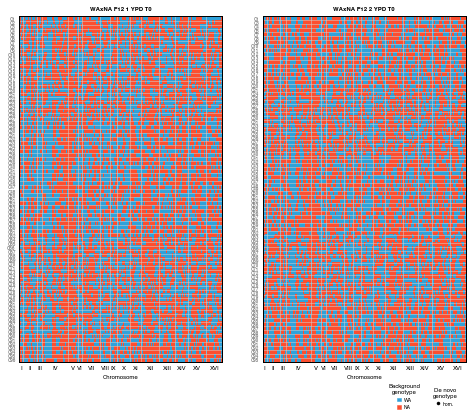

In [17]:
# keep ancestral haploid isolates only
seq_dn_df_sliced = seq_dn_df[(seq_dn_df['type'].isin(['genotype','de novo'])) & \
                             (seq_dn_df['time']==0) & \
                             (seq_dn_df['ploidy']=='haploid')]

seq_dn_df_sliced['clone'] = seq_dn_df_sliced['clone'].astype(int)
seq_dn_df_sliced = seq_dn_df_sliced.sort_values('clone')

seq_dn_df_sliced = pd.pivot_table(seq_dn_df_sliced, 
                                  index=['selection','population','time','set','clone','lineage','type'], 
                                  columns=['chr_arabic','chr_roman','pos','gene'])['genotype']

fig = plt.figure(figsize=(8, 6))

shape = pd.DataFrame({k: 
x.shape for k,x in seq_dn_df_sliced.groupby(level=['population'])
})

grid = gridspec.GridSpec(1, 2, wspace=0.2)
gs = {}

for ii, (p, sdf) in enumerate(seq_dn_df_sliced.groupby(level=['population'])):

    nrows = 1
    ncols = 1
    gs[p] = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                                             subplot_spec=grid[ii],
                                             hspace=0, wspace=0)
    
    # retrieve axis
    ax = plt.subplot(gs[p][:])
    
    ### background genotype ###
    indexer = [slice(None)]*len(sdf.index.names)
    indexer[sdf.index.names.index('type')] = ['genotype']
    gt = sdf.loc[tuple(indexer),:].dropna(axis=1, how='all')
            
    x = gt.columns.get_level_values('pos').values
    y = np.arange(len(gt.index))
    data = gt.fillna(method='pad', axis=1).values
        
    # make a color map of fixed colors
    cmap = plt.cm.colors.ListedColormap([config.background['color']['NA'], 
                                         config.background['color']['WA']])
    bounds = [0,1]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    title = ''
    xlabel= ''
    ylabel= ''
    xticklabels = []
    yticklabels = []
        
    plot.heatmap(np.r_[x, x.max()+1], np.r_[y, y.max()+1], data,
                 ax, title, xlabel, ylabel, xticklabels, yticklabels, cmap=cmap, 
                 vmin=np.nanmin(data), vmax=np.nanmax(data), speed='fast')

    # set title
    ax.set_title(p.replace('_',' ')+' T0', fontsize=6, weight='bold')
    
    # set ticks
    lineage = gt.index.get_level_values('lineage').unique()[0]
    ax.tick_params(axis='y', colors=config.lineages[lineage]['fill'], width=5, which='both')
    
    ### de novo genotype ###
    indexer = [slice(None)]*len(sdf.index.names)
    indexer[sdf.index.names.index('type')] = ['de novo']
    gn = sdf.loc[tuple(indexer),:].dropna(axis=1, how='all')
        
    if len(gn) > 0:
                
        for i,(k,g) in enumerate(gn.groupby(level='clone')):

            g = g.dropna(axis=1)
            x = g.columns.get_level_values('pos').values
            y = np.repeat(g.index.get_level_values('clone').values+.5, len(x))
            data = g.values.flatten()
            ax.scatter(x, y,
                       facecolors=[config.genotype['color'][d] for d in data],
                       edgecolors='lightgray', s=8, rasterized=False, zorder=3)
            
            genes = g.columns.get_level_values('gene')
            loc = zip(x, y-.4)
            
            for l, xy in zip(genes, loc):

                ann = ax.annotate(l, xy=xy, xytext=(0, 0), textcoords='offset points',
                                  bbox=dict(boxstyle="round,pad=0", fc="w", alpha=0.5),
                                  fontsize=4.5, va='bottom', ha='center',
                                  color='k', style=('italic' if l!='non-coding' else 'normal'),
                                  path_effects=[PathEffects.withStroke(linewidth=0.35, foreground='w')])

    # set grid
    xlabels = chr_coords.chr_start + (chr_coords.chr_end - chr_coords.chr_start)/2.
    xstart = chr_coords.chr_start
    ax.set_xticks(xlabels, minor=False)
    ax.set_xticklabels(chr_coords.chr_arabic.apply(utils.int_to_roman), minor=False)
    ax.set_xlabel('Chromosome')
    xgrid=[xst+1. for xst in list(set(xstart))]
    [ax.axvline(g, lw=0.5, ls="-", color="lightgray") for g in xgrid]
    
    ylabels = gt.index.get_level_values('clone').map(str)
    ax.set_yticks(np.arange(len(ylabels)) + 0.5, minor=False)
    ax.set_yticklabels('C' + ylabels, fontweight='bold', va='center', minor=False)
    [ax.axhline(g, lw=0.5, ls="-", color="lightgray") for g in np.arange(len(ylabels))]

# set legend
for k, xy in zip(['WAxNA_F12_2_YPD'],[(2,0),(2,0)]):
    
    ax = plt.subplot(gs[k][:])
    
    wt_artist = patches.Rectangle((0,0), width=1, height=1, color=config.background['color']['WA'])
    hom_artist = patches.Rectangle((0,0), width=1, height=1, color=config.background['color']['NA'])
    
    leg1 = ax.legend([wt_artist,hom_artist], 
                     ['WA','NA'], 
                     bbox_to_anchor=(0.7, -0.1), ncol=1,
                     frameon=False, loc='center',
                     borderaxespad=0, handlelength=0.75, 
                     title='Background\ngenotype', prop={'size':5})
    
    hom_artist = lines.Line2D((0,1),(0,0), mec='k', mfc=config.genotype['color'][2],
                              marker='o', markersize=3, linestyle='')
    
    leg2 = ax.legend([hom_artist], 
                     ['hom.'], 
                     bbox_to_anchor=(0.9, -0.1), ncol=1,
                     frameon=False, loc='center',
                     borderaxespad=0, handlelength=0.75, 
                     title='De novo\ngenotype', prop={'size':5})
    
    ax.add_artist(leg1)
        
    for leg in [leg1,leg2]:
        plt.setp(leg.get_title(),fontsize=6, multialignment='center')

for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='x', which='major', size=2, labelsize=6)
    ax.tick_params(axis='y', which='major', size=2, labelsize=4.5)
    ax.tick_params(axis='both', which='minor', size=1, labelsize=4)

plot.save_figure(dir_supp+'figures/supp_figure_seq_clones/supp_figure_seq_ancestral_clones')
plt.show()

**Fig. S5:** Sequences of ancestral clones sampled from the WAxNA $\text{F}_\text{12}$ founder populations, which were obtained by bulk crossing between the WA and NA parents. Pre-existing and *de novo* SNPs and indels were detected by whole-genome sequencing in single-cell derived clones from ancestral populations at ${t\,{=}\,0}$ days. Chromosomes are shown on the $x$-axis; clone isolates are listed on the left. WA (in blue) and NA (in red) represent haploid genotypes. Individual cells with unique background genotypes carry private *de novo* SNPs and indels (circles).

## Figure 4 - Genome instability in sequences of evolved clones

('HU', 'WAxNA_F12_1_HU_1', (8, 10701))
('HU', 'WAxNA_F12_1_HU_2', (7, 10701))
('HU', 'WAxNA_F12_1_HU_3', (19, 10701))
('HU', 'WAxNA_F12_2_HU_1', (8, 10701))
('HU', 'WAxNA_F12_2_HU_2', (14, 10701))
('HU', 'WAxNA_F12_2_HU_3', (20, 10701))
('RM', 'WAxNA_F12_1_RM_1', (11, 10701))
('RM', 'WAxNA_F12_1_RM_2', (22, 10701))
('RM', 'WAxNA_F12_1_RM_3', (11, 10701))
('RM', 'WAxNA_F12_2_RM_1', (11, 10701))
('RM', 'WAxNA_F12_2_RM_2', (22, 10701))
('RM', 'WAxNA_F12_2_RM_3', (4, 10701))


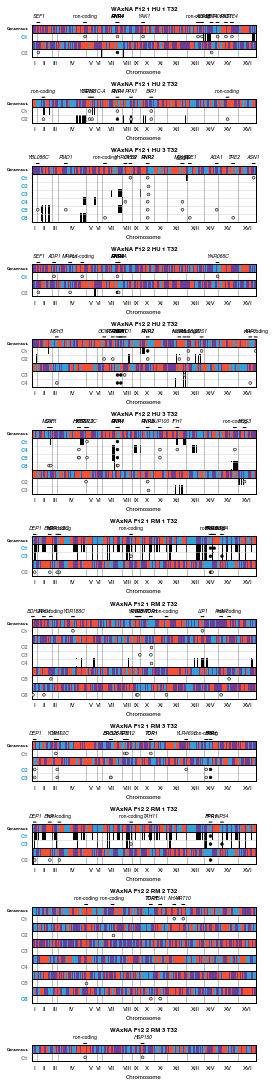

In [18]:
# Keep evolved isolates only
seq_dn_df_sliced = seq_dn_df[(seq_dn_df['type'].isin(['consensus','snp_indel','copy_number','loh'])) & \
                             (seq_dn_df['time']==32)]

seq_dn_df_sliced = pd.pivot_table(seq_dn_df_sliced, 
                                  index=['selection','population','time','set','clone','lineage','type','ploidy'], 
                                  columns=['chr_arabic','chr_roman','pos','gene'])['genotype']

fig = plt.figure(figsize=(4, 18))

indexer = [slice(None)]*len(seq_dn_df_sliced.index.names)
indexer[seq_dn_df_sliced.index.names.index('type')] = ['consensus','loh']
seq_dn_df_shape = seq_dn_df_sliced.loc[tuple(indexer),:].dropna(axis=1, how='all')

shape = pd.DataFrame({k: 
x.shape for k,x in seq_dn_df_shape.groupby(level=['selection','population'])
})

ygrid = shape.ix[0].values
grid = gridspec.GridSpec(len(ygrid), 1, height_ratios=ygrid, hspace=0.9)

gs = {}

for ii, ((e,p), data) in enumerate(seq_dn_df_sliced.groupby(level=['selection','population'])):

    idx = 0
    
    nrows = ygrid[ii]
    ncols = 1
    gs[(e,p)] = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                                                 subplot_spec=grid[ii],
                                                 hspace=0, wspace=0)
    
    ax = gs[(e,p)]
#     ax.text(-0.085, 1.2, 'C', transform=ax.transAxes,
#             fontsize=9, fontweight='bold', va='top', ha='right')
    print(e, p, data.shape)
    plot.genome_instability(data, ax=ax, title=p.replace('_',' ')+' T32')
    
#     if ax.is_first_row():
#         ax.text(-0.185, 1.055, 'A', transform=ax.transAxes,
#                 fontsize=9, fontweight='bold', va='top', ha='right')
    
# axes limits
for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=1, labelsize=4)

plot.save_figure(dir_supp+'figures/supp_figure_seq_clones/supp_figure_seq_evolved_clones')
plt.show()

**Fig. 4:** Genome instability in sequences of evolved clones. SNPs, indels and chromosome-level aberrations were detected by whole-genome sequencing in single-cell derived clones from evolved populations, after ${t\,{=}\,32}$ days in (**A**) hydroxurea or (**B**) rapamycin (see Table S1). Chromosomes are shown on the $x$-axis; clone isolates are listed on the left, colored by lineage (see Fig. S7). The consensus shows the majority genotype across population isolates with sequence identity greater than 80%. WA/WA (in blue) and NA/NA (in red) represent homozygous diploid genotypes and WA/NA (in purple) represents a heterozygous genotype. Individual cells with shared background genotype carry *de novo* SNPs and indels (circles), *de novo* mis-segregations with loss-of-heterozygosity (solid segments) and *de novo* gains or losses in copy number (hatched segments). Driver and passenger mutations are listed along the bottom (drivers are in boldface). Populations marked by $\otimes$ indicate cross-contamination during the selection phase, but any derived events are independent.